In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
torch.set_default_dtype(torch.float64)
import torch.nn as nn
import copy
import random

In [2]:
import config as cfg
from model import DeepNN
from utils import relative_l2, set_seed
from train_reg import train_model_reg
from train_pde import train_model_pde

In [3]:
set_seed(0)
model_E = DeepNN().cuda()
model_T = DeepNN().cuda()
[model_E, model_T] = train_model_reg(model_E, model_T, Nfit=200, lr_E=1e-3, lr_T=1e-4)

E: lbfgs : 0 - ref_rl2 7.6890e-01 
T: lbfgs : 0 - ref_rl2 9.4809e-01 
E: lbfgs : 50 - ref_rl2 4.9279e-02 
T: lbfgs : 50 - ref_rl2 6.3767e-02 
E: lbfgs : 100 - ref_rl2 3.8883e-03 
T: lbfgs : 100 - ref_rl2 2.0992e-02 
E: lbfgs : 150 - ref_rl2 5.7908e-04 
T: lbfgs : 150 - ref_rl2 2.0501e-02 
E: lbfgs : 199 - ref_rl2 3.2893e-04 
T: lbfgs : 199 - ref_rl2 2.0064e-02 


In [4]:
set_seed(50)
model_E_cur = DeepNN().cuda()
model_E_cur.load_state_dict(copy.deepcopy(model_E.state_dict()))
model_T_cur = DeepNN().cuda()
model_T_cur.load_state_dict(copy.deepcopy(model_T.state_dict()))
[model_E_cur, model_T_cur] = train_model_pde(model_E_cur, model_T_cur, Nfit=200, lr_E=1e-1, lr_T=1e-1)

E: adam : 0 - ref_rl2 3.4190e-04 - pde 7.8438e-05 - lbc 1.1085e-02 - rbc 4.4944e-06 - tbc 6.1434e-01 - bbc 1.5802e-02
T: adam : 0 - ref_rl2 1.6504e-02 - pde 2.4712e-03 - lbc 1.8094e-03 - rbc 1.6023e-02 - tbc 2.5072e-02 - bbc 1.6804e-02
E: adam : 10 - ref_rl2 1.2106e-04 - pde 7.7584e-05 - lbc 3.6633e-03 - rbc 3.6176e-07 - tbc 5.1686e-01 - bbc 5.0095e-03
T: adam : 10 - ref_rl2 4.9294e-04 - pde 4.0031e-06 - lbc 1.6187e-04 - rbc 3.2393e-02 - tbc 1.8671e-02 - bbc 5.4223e-04
E: adam : 20 - ref_rl2 4.2781e-05 - pde 7.7285e-05 - lbc 2.5183e-04 - rbc 3.4067e-07 - tbc 2.8833e-01 - bbc 1.2920e-03
T: adam : 20 - ref_rl2 4.9209e-04 - pde 4.1116e-06 - lbc 1.5448e-04 - rbc 3.2438e-02 - tbc 1.8138e-02 - bbc 5.3834e-04
E: adam : 30 - ref_rl2 2.6982e-05 - pde 7.7216e-05 - lbc 3.3576e-05 - rbc 5.9191e-07 - tbc 1.2411e-01 - bbc 8.4014e-04
T: adam : 30 - ref_rl2 4.9210e-04 - pde 4.1117e-06 - lbc 1.5432e-04 - rbc 3.2438e-02 - tbc 1.8146e-02 - bbc 5.3821e-04
E: adam : 40 - ref_rl2 2.1159e-05 - pde 7.7190e-05

In [5]:
X = cfg.X.detach().cpu()
Y = cfg.Y.detach().cpu()
E_reg = model_E(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
E_pinn = model_E_cur(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
E_ref = cfg.E_ref.cpu()
T_reg = model_T(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
T_pinn = model_T_cur(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
T_ref = cfg.T_ref.cpu()

In [7]:
print('E: Regression Solution rl2: {:.4e}'.format(relative_l2(E_ref, E_reg)))
print('E: PINN Solution rl2: {:.4e}'.format(relative_l2(E_ref, E_pinn)))

print('T: Regression Solution rl2: {:.4e}'.format(relative_l2(T_ref, T_reg)))
print('T: PINN Solution rl2: {:.4e}'.format(relative_l2(T_ref, T_pinn)))

E: Regression Solution rl2: 3.2893e-04
E: PINN Solution rl2: 9.5702e-06
T: Regression Solution rl2: 2.0064e-02
T: PINN Solution rl2: 4.9225e-04


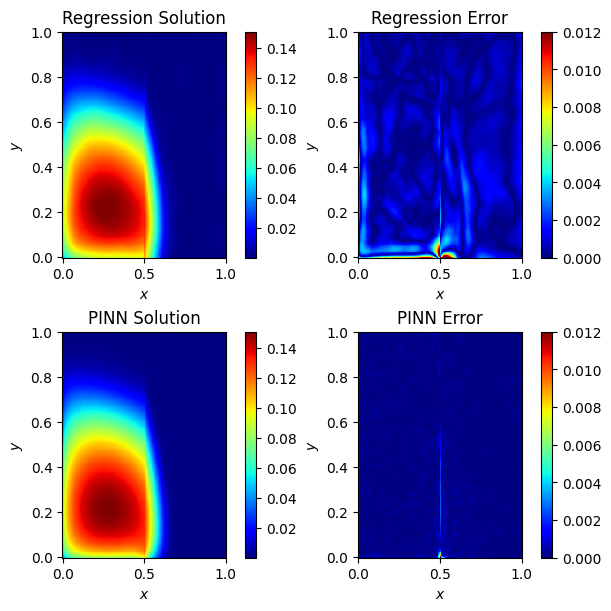

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout='constrained')

vmin = E_ref.min()
vmax = E_ref.max()

pcm = axs[0][0].pcolormesh(X, Y, E_reg, vmin=vmin, vmax=vmax, cmap='jet')
axs[0][0].set_title("Regression Solution")
axs[0][0].set_xlabel("$x$")
axs[0][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][0])

pcm = axs[0][1].pcolormesh(X, Y, (E_ref - E_reg).abs(), vmin=0, vmax=0.012, cmap='jet')
axs[0][1].set_title("Regression Error")
axs[0][1].set_xlabel("$x$")
axs[0][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][1])

pcm = axs[1][0].pcolormesh(X, Y, E_pinn, vmin=vmin, vmax=vmax, cmap='jet')
axs[1][0].set_title("PINN Solution")
axs[1][0].set_xlabel("$x$")
axs[1][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][0])

pcm = axs[1][1].pcolormesh(X, Y, (E_ref - E_pinn).abs(), vmin=0, vmax=0.012, cmap='jet')
axs[1][1].set_title("PINN Error")
axs[1][1].set_xlabel("$x$")
axs[1][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][1])

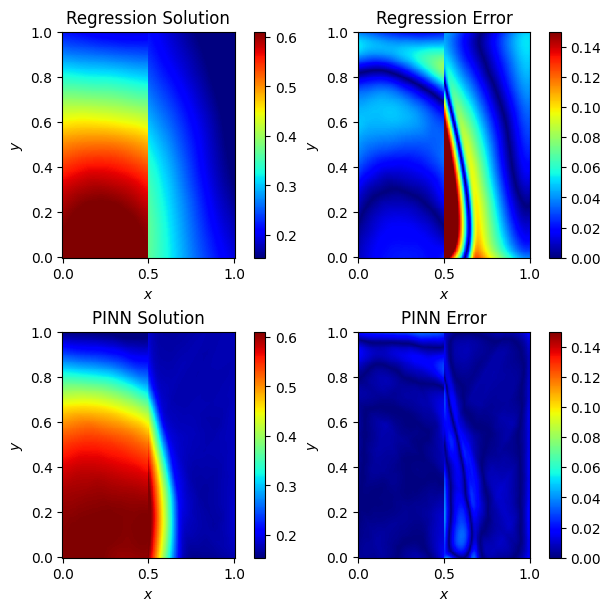

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout='constrained')

vmin = T_ref.min()
vmax = T_ref.max()

pcm = axs[0][0].pcolormesh(X, Y, T_reg, vmin=vmin, vmax=vmax, cmap='jet')
axs[0][0].set_title("Regression Solution")
axs[0][0].set_xlabel("$x$")
axs[0][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][0])

pcm = axs[0][1].pcolormesh(X, Y, (T_ref - T_reg).abs(), vmin=0, vmax=0.15, cmap='jet')
axs[0][1].set_title("Regression Error")
axs[0][1].set_xlabel("$x$")
axs[0][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][1])

pcm = axs[1][0].pcolormesh(X, Y, T_pinn, vmin=vmin, vmax=vmax, cmap='jet')
axs[1][0].set_title("PINN Solution")
axs[1][0].set_xlabel("$x$")
axs[1][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][0])

pcm = axs[1][1].pcolormesh(X, Y, (T_ref - T_pinn).abs(), vmin=0, vmax=0.15, cmap='jet')
axs[1][1].set_title("PINN Error")
axs[1][1].set_xlabel("$x$")
axs[1][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][1])